In [1]:
import math
from tensorboardX import SummaryWriter
sess = None

In [2]:
import tensorflow as tf
import collections
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.8)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
from gym import envs
#print(envs.registry.all())

4
done
(84, 84, 4)


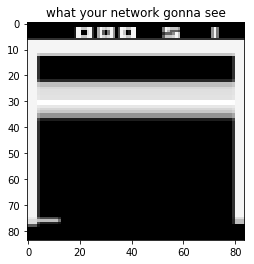

In [4]:
from wrappers import make_atari_deepmind
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#env_name = "PongNoFrameskip-v4"
env_name = "BreakoutNoFrameskip-v4"
env = make_atari_deepmind(env_name)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print(n_actions)
obs = env.reset()
obs, r, done, _ = env.step(2)
#print(obs.shape)
#print(is_done)
done = False
for _ in range(2000):
    obs, _, done, _ = env.step(3)
    obs = np.array(obs)
    if done:
        print('done')
        break
plt.title("what your network gonna see")
print (obs.shape)
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

In [5]:

from dqnagent import DQNAgent

import networks


#agent.epsilon = 0.5

breakout_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 2,
    'EPSILON' : 0,
    'MIN_EPSILON' : 0,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'ENDDDQN2',
    'IS_DOUBLE' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 420,
    'NUM_STEPS_FILL_BUFFER' : 10000,
    'REPLAY_BUFFER_TYPE' : 'notmal',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'LIVES_REWARD' : 5,
    'NETWORK' : networks.AtariNoisyDuelingDQN()
    }


pong_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 4,
    'EPSILON' : 1.0,
    'MIN_EPSILON' : 0.02,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'PongDDDQN',
    'IS_DOUBLE' : True,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 20,
    'NUM_STEPS_FILL_BUFFER' : 10000,
    'REPLAY_BUFFER_TYPE' : 'prioritized',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'NETWORK' : networks.AtariDuelingDQN(),
    'LIVES_REWARD' : 1
    }
agent = DQNAgent(env, sess, env_name, config = breakout_dddqn_config)
#agent.restore('nn/NDDDQNBreakoutNoFrameskip-v4')
#agent.epsilon = 0.02

In [6]:
env.reset()
agent.train()

848
saving next best rewards:  3.0
4.4185e-05
Frames per seconds:  193.9419855861703
1528
0.00055759
Frames per seconds:  195.91140943371647
2176
0.00509188
2648
0.00192835
Frames per seconds:  194.69307195416084
3176
0.00220087
3680
0.00309501
Frames per seconds:  194.392304365325
4264
0.00282597
4816
0.000830972
Frames per seconds:  194.6174406534069
5256
0.00293777
Frames per seconds:  194.57978243623046
6016
0.000693335
6600
0.00100554
Frames per seconds:  194.46841895327844
7192
0.00237769
7856
0.000795157
Frames per seconds:  195.0728558726301
8360
0.000744467
8968
0.00114711
Frames per seconds:  194.54301405807675
9624
0.000920113
Frames per seconds:  195.30000870730916
10488
0.000338648
Frames per seconds:  195.37705434400388
11040
0.000848838
11504
0.00045742
Frames per seconds:  193.15546971899573
12088
0.000582909
12640
0.000320059
Frames per seconds:  194.39118720006883
13376
0.000839647
Frames per seconds:  196.178913801379
14224
0.000694606
Frames per seconds:  196.795847

142192
saving next best rewards:  17.75
9.31785e-05
Frames per seconds:  187.415065550974
Frames per seconds:  187.3448397786186
144480
8.05605e-05
Frames per seconds:  187.41479757340005
Frames per seconds:  187.76596011377237
146728
saving next best rewards:  18.5
0.00011648
Frames per seconds:  187.18232298651
Frames per seconds:  185.57739011796363
Frames per seconds:  186.75271213719603
149000
0.000148828
Frames per seconds:  186.36984258621712
150936
0.000125136
Frames per seconds:  186.36989227321286
Frames per seconds:  187.03123788359304
152848
8.5745e-05
Frames per seconds:  186.61366048243386
Frames per seconds:  187.20501390992226
154584
3.84475e-05
Frames per seconds:  187.592106460152
Frames per seconds:  186.68303993565823
156624
7.62077e-05
Frames per seconds:  187.6615185933404
Frames per seconds:  187.9437743812935
158576
9.35703e-05
Frames per seconds:  187.44990916220834
Frames per seconds:  188.43632904115412
Frames per seconds:  187.1010534310548
161216
saving nex

Frames per seconds:  176.0615238796043
Frames per seconds:  175.8646492140292
310744
0.000102475
Frames per seconds:  176.43391487104327
Frames per seconds:  176.83768000383162
Frames per seconds:  175.87619749842838
313904
0.000156341
Frames per seconds:  176.99374658982583
Frames per seconds:  176.8064609520418
Frames per seconds:  177.08649900709554
316216
0.000157092
Frames per seconds:  176.9000243567858
Frames per seconds:  176.55759532008952
Frames per seconds:  177.43233576969953
319752
saving next best rewards:  36.0
0.000142128
Frames per seconds:  177.0571502771077
Frames per seconds:  172.66653806123776
Frames per seconds:  174.52994552846658
322592
0.000151981
Frames per seconds:  173.05311817549054
Frames per seconds:  173.17361117935067
Frames per seconds:  172.51724687530526
325688
0.000129713
Frames per seconds:  173.08299000198366
Frames per seconds:  173.68344837612983
Frames per seconds:  173.6233071195216
328776
8.26436e-05
Frames per seconds:  174.4069274034508
Fr

484952
0.000166111
Frames per seconds:  167.58645409848438
Frames per seconds:  166.72353565017465
Frames per seconds:  167.47533341806317
487664
0.000175433
Frames per seconds:  166.65200521391458
Frames per seconds:  167.25183952723077
Frames per seconds:  167.02892138677
490944
0.000135029
Frames per seconds:  166.00506923896506
Frames per seconds:  166.47357951353308
Frames per seconds:  167.08458021886653
Frames per seconds:  167.8389128924356
Frames per seconds:  167.41713522304602
495344
0.000212867
Frames per seconds:  167.89084539642764
Frames per seconds:  166.529596088196
Frames per seconds:  167.00109590009774
Frames per seconds:  167.64338975945796
499064
0.000104119
Frames per seconds:  166.8892225547209
Frames per seconds:  167.67130906102597
Frames per seconds:  167.30690626278817
502416
0.000184597
Frames per seconds:  167.50329710774642
Frames per seconds:  167.47453096255458
Frames per seconds:  166.77823510122016
505752
0.000179427
Frames per seconds:  167.084520314

Frames per seconds:  156.92833661434705
Frames per seconds:  157.60294946407234
Frames per seconds:  159.28111321909319
Frames per seconds:  159.61076366806898
667592
0.000311924
Frames per seconds:  157.33097186432917
Frames per seconds:  158.05083856397593
Frames per seconds:  156.32530227130462
670960
saving next best rewards:  124.25
0.000287056
Frames per seconds:  157.47853759523824
Frames per seconds:  154.99681991306838
Frames per seconds:  155.7673509522381
Frames per seconds:  157.97681991906404
674376
0.000380238
Frames per seconds:  159.10026633897067
Frames per seconds:  160.17165613202565
Frames per seconds:  159.96649261432856
677800
0.000375255
Frames per seconds:  159.84029628599842
Frames per seconds:  159.78880453112052
Frames per seconds:  159.58461393176955
Frames per seconds:  160.6336026961817
681064
0.000261702
Frames per seconds:  159.91552314130934
Frames per seconds:  159.73718777051764
Frames per seconds:  160.0949965542374
684392
0.000214193
Frames per seco

Frames per seconds:  156.81423820928578
844440
0.000355671
Frames per seconds:  156.73213053442643
Frames per seconds:  157.10912591777068
Frames per seconds:  156.98677308255995
Frames per seconds:  156.54560467366358
848528
0.000680287
Frames per seconds:  157.62786727853717
Frames per seconds:  157.08520723014473
Frames per seconds:  157.90087322190396
851520
0.000568911
Frames per seconds:  156.9130900289258
Frames per seconds:  156.25287318297487
Frames per seconds:  157.13437053233034
854408
0.000660253
Frames per seconds:  156.13051892921138
Frames per seconds:  156.3496195283743
Frames per seconds:  154.37584982917014
Frames per seconds:  155.9605385223799
858336
0.000350359
Frames per seconds:  152.7297573273108
Frames per seconds:  152.94717954154106
Frames per seconds:  153.12629729444276
Frames per seconds:  153.36044918118623
862224
0.000584901
Frames per seconds:  151.32374143598204
Frames per seconds:  152.47419804802823
Frames per seconds:  152.01199423251612
865880
0.0

Frames per seconds:  151.57529670864042
Frames per seconds:  152.2889155030244
1022656
0.00056609
Frames per seconds:  151.7819607874358
Frames per seconds:  151.30087497440175
Frames per seconds:  152.47486873534208
1025152
0.000650109
Frames per seconds:  151.84982510839876
Frames per seconds:  152.91608133291743
1027792
0.000959139
Frames per seconds:  152.4974094771325
Frames per seconds:  152.89335535508803
Frames per seconds:  153.00937484769483
Frames per seconds:  152.10476117946988
1031616
0.000594817
Frames per seconds:  153.102871686315
Frames per seconds:  152.79948513875877
Frames per seconds:  152.4981136361645
Frames per seconds:  151.96579633363618
1035288
0.000700991
Frames per seconds:  153.00945857510803
Frames per seconds:  152.6599597726121
Frames per seconds:  152.66058764388373
1038304
0.000848355
Frames per seconds:  151.8266894725632
Frames per seconds:  152.4278794733922
Frames per seconds:  152.15032610554374
1041344
0.000518052
Frames per seconds:  152.05801

Frames per seconds:  148.47783898770234
Frames per seconds:  148.03936531081283
1201888
0.000621132
Frames per seconds:  146.63213474970968
Frames per seconds:  144.89463082356298
Frames per seconds:  141.92064950417486
1204448
0.00054831
Frames per seconds:  144.16556238831544
Frames per seconds:  143.362165132699
Frames per seconds:  145.02040718668215
1207296
0.00045353
Frames per seconds:  147.10534223748334
Frames per seconds:  145.44108365657877
Frames per seconds:  147.86508898460605
1210008
0.000383472
Frames per seconds:  146.07437718629876
Frames per seconds:  147.62608312435526
Frames per seconds:  143.3406224195688
1213504
0.000346825
Frames per seconds:  144.26919106381462
Frames per seconds:  143.23873386410014
Frames per seconds:  145.758767263508
1216296
0.00055477
Frames per seconds:  145.1048245829196
Frames per seconds:  145.39897425927902
Frames per seconds:  146.22585613583055
1219072
0.000543121
Frames per seconds:  145.39884320966766
Frames per seconds:  144.6229

Frames per seconds:  145.95019478275964
1378768
0.000587754
Frames per seconds:  145.2093660661514
Frames per seconds:  145.20937612062596
Frames per seconds:  144.89452570881332
Frames per seconds:  145.86490786415695
1382144
0.000485342
Frames per seconds:  145.1252337570044
Frames per seconds:  144.12455967709093
Frames per seconds:  144.79054186539113
Frames per seconds:  146.35388379318005
1386464
0.00068431
Frames per seconds:  145.67473598975613
Frames per seconds:  144.68469577297424
Frames per seconds:  145.69586757407006
1389984
0.00047672
Frames per seconds:  146.2205137671417
Frames per seconds:  145.02416289106188
Frames per seconds:  145.37839732384492
1392760
0.000479661
Frames per seconds:  145.99171959063045
Frames per seconds:  145.06227749391502
Frames per seconds:  145.5260775001695
Frames per seconds:  145.3994430155919
1396384
0.000556246
Frames per seconds:  144.72788557567486
Frames per seconds:  144.9784257389743
Frames per seconds:  145.97038018351748
1399520


Frames per seconds:  141.70032115060158
Frames per seconds:  143.20404045121913
1558192
0.000476492
Frames per seconds:  143.17161188490846
Frames per seconds:  143.46471032473247
Frames per seconds:  145.37776745811394
1561680
0.000658931
Frames per seconds:  143.87584407733112
Frames per seconds:  143.34164135130544
Frames per seconds:  144.76911741453503
1564792
0.000843847
Frames per seconds:  144.00232419522732
Frames per seconds:  144.7272813097746
Frames per seconds:  141.68026561266532
1567824
0.000758446
Frames per seconds:  140.50888401353262
Frames per seconds:  140.44966150367958
Frames per seconds:  141.06302218164552
Frames per seconds:  141.92082238001564
1571072
0.000551304
Frames per seconds:  143.58740585290917
Frames per seconds:  141.5602091685689
Frames per seconds:  142.66854519244572
1574560
0.00054828
Frames per seconds:  144.33205170209146
Frames per seconds:  143.85515323047508
Frames per seconds:  140.6862475609359
1577560
0.000856644
Frames per seconds:  140

Frames per seconds:  140.39184225197633
Frames per seconds:  136.65948979398007
1739704
0.000472473
Frames per seconds:  137.1011337513885
Frames per seconds:  136.02918402610325
Frames per seconds:  136.62228458053045
1742224
0.000497547
Frames per seconds:  139.02581456626393
Frames per seconds:  135.58775001422373
Frames per seconds:  135.82648294265755
Frames per seconds:  134.31629682031937
1746504
0.000596193
Frames per seconds:  137.63382147030438
Frames per seconds:  138.66281868317293
Frames per seconds:  139.33776900721426
Frames per seconds:  138.68198313691119
1750368
0.000759441
Frames per seconds:  139.35103206811613
Frames per seconds:  135.14912821919356
Frames per seconds:  137.48400028727286
Frames per seconds:  139.00936525115853
1754312
0.000434162
Frames per seconds:  139.22119519272258
Frames per seconds:  136.30706892341536
Frames per seconds:  137.69215264140325
Frames per seconds:  136.15860906239647
1758384
0.000352799
Frames per seconds:  137.76735119552143
F

1919056
0.000429201
Frames per seconds:  134.2089024225767
Frames per seconds:  135.13086672403566
Frames per seconds:  134.6951955291116
1922480
0.000519183
Frames per seconds:  134.80434907604808
Frames per seconds:  135.00343937695376
Frames per seconds:  134.62282855378828
Frames per seconds:  134.9852823926232
1926152
0.000405006
Frames per seconds:  134.2994207260346
Frames per seconds:  134.13147180616266
Frames per seconds:  135.4778453736167
Frames per seconds:  134.80385082968425
1930144
0.000356865
Frames per seconds:  134.56870903034326
Frames per seconds:  134.1900655231328
Frames per seconds:  134.9309362276849
1933872
0.000675464
Frames per seconds:  134.89498282995595
Frames per seconds:  134.85823773957708
Frames per seconds:  135.20361981615187
Frames per seconds:  134.6049552278409
1937072
0.000459123
Frames per seconds:  135.82646974702484
Frames per seconds:  132.52324968322637
Frames per seconds:  134.01103367002042
1940400
0.000601112
Frames per seconds:  133.475

2101448
0.000578947
Frames per seconds:  132.15693409060847
Frames per seconds:  133.42258914203342
Frames per seconds:  133.9395580397971
Frames per seconds:  133.85009212456845
2105856
0.000529229
Frames per seconds:  133.90372911138297
Frames per seconds:  133.6004000968708
Frames per seconds:  133.7612959350165
Frames per seconds:  133.35163791569138
2109504
0.000970794
Frames per seconds:  133.605528230452
Frames per seconds:  133.85413732968863
Frames per seconds:  132.4531720077574
Frames per seconds:  133.24580961341724
Frames per seconds:  133.28077058029749
2114032
0.000816877
Frames per seconds:  130.69270933676887
Frames per seconds:  132.9988921050331
Frames per seconds:  132.4213236297912
Frames per seconds:  132.6635731789006
2118240
0.000858015
Frames per seconds:  132.26111004247562
Frames per seconds:  133.19228380361082
Frames per seconds:  132.97020367662913
2121864
0.000611013
Frames per seconds:  133.06231280942518
Frames per seconds:  132.82169337221555
Frames pe

Frames per seconds:  125.2556295846091
Frames per seconds:  124.3550586589276
2285608
0.00069427
Frames per seconds:  120.45587376978565
Frames per seconds:  128.74610900456665
Frames per seconds:  128.4980948183483
Frames per seconds:  125.08375590526103
2289096
0.000498531
Frames per seconds:  127.97332977694559
Frames per seconds:  129.36030046178033
Frames per seconds:  123.44566928559128
Frames per seconds:  123.42090295473945
2293312
0.000440051
Frames per seconds:  124.17728519160566
Frames per seconds:  124.86566526739337
Frames per seconds:  122.78611658413992
2296608
0.000522035
Frames per seconds:  124.73821446113726
Frames per seconds:  124.06267958982302
Frames per seconds:  127.3718748968443
Frames per seconds:  127.50137189314688
2300760
0.000446149
Frames per seconds:  121.19843328426029
Frames per seconds:  126.56838059739326
Frames per seconds:  127.97329463535411
Frames per seconds:  127.71254543834657
2304696
0.000623105
Frames per seconds:  127.7229641821519
Frames

Frames per seconds:  116.73940037704594
Frames per seconds:  118.61729185241695
2467048
0.000531633
Frames per seconds:  118.78746780523689
Frames per seconds:  116.83460772434157
Frames per seconds:  116.79343339898612
Frames per seconds:  120.78916549606046
2471184
0.00089891
Frames per seconds:  116.49555874125257
Frames per seconds:  116.3465449952351
Frames per seconds:  120.28135653083008
Frames per seconds:  120.71433299660102
2475544
0.000484687
Frames per seconds:  117.49172946467516
Frames per seconds:  116.48135605797452
Frames per seconds:  115.84937733677553
2478560
0.000603526
Frames per seconds:  114.94609079249886
Frames per seconds:  115.99626294540899
Frames per seconds:  119.32312448255098
Frames per seconds:  120.4844687271388
2482064
0.000577402
Frames per seconds:  116.69825415482727
Frames per seconds:  118.28198422964782
Frames per seconds:  116.27909684581573
2485792
0.000604209
Frames per seconds:  119.36599338007869
Frames per seconds:  116.6033109548488
Fram

Frames per seconds:  120.90580189328107
2648824
0.000697149
Frames per seconds:  120.5134893206181
Frames per seconds:  121.06467655459201
Frames per seconds:  121.19843678640527
2651856
0.000920636
Frames per seconds:  120.0807156475161
Frames per seconds:  120.87699965030635
Frames per seconds:  120.34671918996517
Frames per seconds:  120.92027788429529
2655304
0.000706756
Frames per seconds:  120.36912359147625
Frames per seconds:  120.36871597584604
2657792
0.0010642
Frames per seconds:  120.23878253324867
Frames per seconds:  120.22477249956474
Frames per seconds:  119.95115933658718
2660632
0.000807561
Frames per seconds:  119.30922179785908
Frames per seconds:  120.12395527084557
Frames per seconds:  120.08042343117451
2663672
0.000919986
Frames per seconds:  120.00854362276215
Frames per seconds:  120.74568905943421
Frames per seconds:  120.81834351563617
Frames per seconds:  119.36564008842093
2667744
0.000460138
Frames per seconds:  120.23920650398226
Frames per seconds:  119

2829672
0.000484337
Frames per seconds:  118.98357717288788
Frames per seconds:  116.50879073446134
Frames per seconds:  118.29536493745424
Frames per seconds:  119.04019461008377
2833224
0.000540285
Frames per seconds:  118.93812569141599
Frames per seconds:  119.04077571950803
Frames per seconds:  119.42291082354693
Frames per seconds:  117.82274406305179
2837736
0.000487618
Frames per seconds:  118.7717960819645
Frames per seconds:  119.26436565112202
Frames per seconds:  115.83537655368059
Frames per seconds:  118.8844458630432
Frames per seconds:  118.58767173997944
2842024
0.000691273
Frames per seconds:  117.9056791448348
Frames per seconds:  118.95494790199129
Frames per seconds:  118.95572722938611
2845648
0.000471584
Frames per seconds:  118.60315069592862
Frames per seconds:  119.32303961747022
Frames per seconds:  118.95534937240429
Frames per seconds:  118.79620863067525
2849584
0.000515466
Frames per seconds:  118.61767427396553
Frames per seconds:  118.50589755791853
Fra

3012952
0.000457025
Frames per seconds:  110.38993219933313
Frames per seconds:  108.9032014701334
Frames per seconds:  105.43371353333167
Frames per seconds:  108.93867989032016
Frames per seconds:  108.42071394854432
Frames per seconds:  110.38992929397939
3018368
0.000546128
Frames per seconds:  108.3272906203837
Frames per seconds:  108.24889443279432
Frames per seconds:  108.60829515616736
Frames per seconds:  110.34130928652914
Frames per seconds:  108.60860170086765
3023040
0.00079807
Frames per seconds:  107.39472520670066
Frames per seconds:  108.16307436902484
Frames per seconds:  107.16884620479101
Frames per seconds:  108.02316483387426
3027416
0.000638499
Frames per seconds:  110.37777172799615
Frames per seconds:  111.51949885057361
Frames per seconds:  110.96411034186744
Frames per seconds:  107.7893656510778
3031112
0.00057529
Frames per seconds:  108.39695011594841
Frames per seconds:  111.0873744021011
Frames per seconds:  112.49539315939724
Frames per seconds:  107.5

KeyboardInterrupt: 

In [7]:
#agent.epsilon = 0.2
#agent.train()
import wrappers

In [12]:
#env_monitor.close()
print(env.unwrapped.get_action_meanings())
def evaluate(env,t_max=10000):
    rewards = []
    env._max_episode_steps = 9999
    print('reset')
    #env = env.old_env
    s = env.reset()
    reward = 0
    for it in range(t_max):
        #e.render()
        qvalues = agent.get_qvalues([s])
        action = np.argmax(qvalues)
        s, r, done, _ = env.step(action)
        reward += r
        
            
        if done:
            
            break       
        
    return reward

import gym.wrappers
env_monitor = wrappers.make_atari_deepmind(env_name)
env_monitor = wrappers.ReallyDoneWrapper(env_monitor)
env_monitor = gym.wrappers.Monitor(env_monitor,directory='video_dddqn01',force=True, write_upon_reset=True)
sessions = [print('reward:', evaluate(env_monitor)) for _ in range(1)]
env_monitor.close()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']
reset
lives: 4
lives: 3
lives: 2
lives: 1
lives: 0
reward: 290.0


In [ ]:
#tf.reset_default_graph()
#agent = DQNAgent(env, sess, ExperienceBuffer(EXP_BUFFER_CAPACITY), env_name, config = dqn_config)

In [ ]:
#env.reset()
#agent.train()

In [1]:
from experience import ReplayBuffer
import wrappers
import gym
import time
env = None
def play_step(buf, env, curr_state):
    action = env.action_space.sample()
    
    # do step in the environment
    new_state, reward, is_done, _ = env.step(action)
    curr_state = new_state
    buf.add(curr_state, action, reward, is_done, new_state)
    if is_done:
        curr_state = env.reset() 
    return curr_state

def do_test():
    buf = None
    buf = ReplayBuffer(100000)
    frame = 0
    dt = 0
    env = wrappers.make_atari_deepmind("BreakoutNoFrameskip-v4")
    curr_state = env.reset() 
    while True:
        frame += 1
        t1 = time.time()
        curr_state = play_step(buf, env, curr_state)
        t2 = time.time()
        dt += t2 - t1
        
        if frame % 1000 == 0 and frame != 0:
            print(dt)
            print(frame)
            dt = 0
            
        

In [ ]:
do_test()

0.9404847621917725
1000
0.9161114692687988
2000
0.9145543575286865
3000
0.9434559345245361
4000
0.909949779510498
5000
0.9105842113494873
6000
0.9404644966125488
7000
0.9225339889526367
8000
0.9305374622344971
9000
0.9354696273803711
10000
0.9275193214416504
11000
0.9704241752624512
12000
0.9414634704589844
13000
0.9364941120147705
14000
0.9305293560028076
15000
0.9743754863739014
16000
0.9404828548431396
17000
0.9514567852020264
18000
0.9444730281829834
19000
0.9484877586364746
20000
0.9544229507446289
21000
0.8936097621917725
22000
0.9305112361907959
23000
0.9415011405944824
24000
0.9334838390350342
25000
0.9644215106964111
26000
0.9364941120147705
27000
0.9444739818572998
28000
0.949460506439209
29000
0.9175460338592529
30000
0.984368085861206
31000
0.936521053314209
32000
0.9574129581451416
33000
0.9803788661956787
34000
0.958437442779541
35000
0.9803972244262695
36000
1.0661280155181885
37000
1.0003249645233154
38000
1.041214942932129
39000
1.130976915359497
40000
1.17784667015075

1.0337839126586914
323000
1.0273244380950928
324000
1.0379226207733154
325000
1.0345582962036133
326000
1.057302713394165
327000
1.0529749393463135
328000
1.0062100887298584
329000
1.013045310974121
330000
1.0527117252349854
331000
1.0429599285125732
332000
1.06900954246521
333000
1.085197925567627
334000
1.0369906425476074
335000
1.0597114562988281
336000
1.028831958770752
337000
0.9970366954803467
338000
1.0414395332336426
339000
1.0258898735046387
340000
1.079709768295288
341000
1.0626931190490723
342000
1.0897562503814697
343000
1.0711441040039062
344000
1.1473724842071533
345000
1.0175511837005615
346000
1.0695338249206543
347000
1.0227718353271484
348000
1.0920791625976562
349000
1.038224697113037
350000
1.0442073345184326
351000
1.0818252563476562
352000
1.0250322818756104
353000
1.030308485031128
354000
1.0149445533752441
355000
1.0144574642181396
356000
1.031165599822998
357000
1.0479705333709717
358000
1.0779879093170166
359000
1.0360145568847656
360000
1.051119327545166
3610

1.0232627391815186
642000
1.0212929248809814
643000
1.1090328693389893
644000
1.0900816917419434
645000
1.009300947189331
646000
0.9953658580780029
647000
0.9803485870361328
648000
1.0611627101898193
649000
1.0861854553222656
650000
0.9853963851928711
651000
1.0990540981292725
652000
1.028243064880371
653000
1.0382323265075684
654000
1.0341792106628418
655000
1.0541784763336182
656000
1.0203006267547607
657000
1.135958194732666
658000
1.1000559329986572
659000
1.065152883529663
660000
1.0442264080047607
661000
1.0262553691864014
662000
0.9963157176971436
663000
0.9893739223480225
664000
1.001302719116211
665000
0.9973597526550293
666000
0.9763805866241455
667000
1.0013020038604736
668000
1.0182950496673584
669000
1.00730562210083
670000
1.0102782249450684
671000
0.9723989963531494
672000
1.017298698425293
673000
1.0092809200286865
674000
0.9773857593536377
675000
0.9973325729370117
676000
1.0083231925964355
677000
1.0152840614318848
678000
0.9813992977142334
679000
1.0242364406585693
6

0.9802193641662598
961000
0.9986770153045654
962000
1.0039513111114502
963000
1.0129082202911377
964000
1.0348525047302246
965000
1.0302634239196777
966000
1.0117995738983154
967000
1.0181283950805664
968000
1.031898021697998
969000
1.0307857990264893
970000
1.0030596256256104
971000
0.9732208251953125
972000
1.0318543910980225
973000
1.057917594909668
974000
1.019244909286499
975000
1.0159385204315186
976000
1.036008358001709
977000
1.0068862438201904
978000
1.045487642288208
979000
1.0496554374694824
980000
1.03334641456604
981000
0.9921894073486328
982000
1.0615036487579346
983000
0.9562702178955078
984000
1.0020182132720947
985000
1.0114076137542725
986000
1.0233826637268066
987000
1.0048327445983887
988000
1.0660395622253418
989000
1.0148470401763916
990000
0.9910399913787842
991000
1.021127700805664
992000
1.0229430198669434
993000
1.027214765548706
994000
1.028519630432129
995000
0.9706928730010986
996000
1.030285120010376
997000
1.0007195472717285
998000
0.9979655742645264
9990

1.022557258605957
1269000
1.0592882633209229
1270000
1.045194387435913
1271000
1.0121088027954102
1272000
1.003730058670044
1273000
0.9983596801757812
1274000
1.0275263786315918
1275000
1.018718957901001
1276000
1.022378921508789
1277000
1.0467636585235596
1278000
1.0539271831512451
1279000
1.0530109405517578
1280000
1.0190057754516602
1281000
0.9964346885681152
1282000
1.003861904144287
1283000
0.9897818565368652
1284000
0.9872183799743652
1285000
1.016829490661621
1286000
1.0282983779907227
1287000
0.9970059394836426
1288000
1.0069210529327393
1289000
1.0833582878112793
1290000
0.9996509552001953
1291000
1.0028321743011475
1292000
1.0150587558746338
1293000
0.990236759185791
1294000
1.0040733814239502
1295000
1.0133471488952637
1296000
1.0275282859802246
1297000
1.0227339267730713
1298000
1.024061679840088
1299000
1.0282092094421387
1300000
1.0194551944732666
1301000
1.0092918872833252
1302000
1.014023780822754
1303000
1.0337984561920166
1304000
1.0008289813995361
1305000
1.054030179

1.039722204208374
1575000
1.035904884338379
1576000
1.009932279586792
1577000
1.0132849216461182
1578000
1.0567431449890137
1579000
1.0578265190124512
1580000
1.0168771743774414
1581000
0.9775848388671875
1582000
1.0567073822021484
1583000
1.0248305797576904
1584000
1.0069286823272705
1585000
0.9650363922119141
1586000
0.9631533622741699
1587000
1.0189540386199951
1588000
1.0275893211364746
1589000
1.0400755405426025
1590000
1.02189302444458
1591000
1.0132708549499512
1592000
1.0287961959838867
1593000
1.0029926300048828
1594000
1.005000352859497
1595000
1.003828763961792
1596000
1.0349133014678955
1597000
1.002227544784546
1598000
0.9981231689453125
1599000
1.0153687000274658
1600000
0.9885213375091553
1601000
0.9962465763092041
1602000
1.0239739418029785
1603000
1.0056076049804688
1604000
1.0311799049377441
1605000
0.9881293773651123
1606000
1.0266914367675781
1607000
1.026944875717163
1608000
1.0286035537719727
1609000
1.0505895614624023
1610000
1.0090265274047852
1611000
1.02017474

1.0251989364624023
1882000
1.0080311298370361
1883000
1.037735939025879
1884000
1.032665729522705
1885000
1.0211052894592285
1886000
1.0179226398468018
1887000
1.0383946895599365
1888000
1.0300407409667969
1889000
0.9856574535369873
1890000
1.0398600101470947
1891000
1.003833293914795
1892000
1.0336859226226807
1893000
1.010190725326538
1894000
1.0134012699127197
1895000
1.0001521110534668
1896000
0.9907219409942627
1897000
1.0466432571411133
1898000
1.0597875118255615
1899000
1.03298020362854
1900000
1.041762113571167
1901000
1.0416007041931152
1902000
1.0460541248321533
1903000
1.0618815422058105
1904000
1.0110013484954834
1905000
1.0308964252471924
1906000
1.0401315689086914
1907000
1.0218400955200195
1908000
1.0198280811309814
1909000
1.023017406463623
1910000
1.0276532173156738
1911000
1.0358545780181885
1912000
1.0580942630767822
1913000
1.022350788116455
1914000
1.025660514831543
1915000
1.025165319442749
1916000
1.0133631229400635
1917000
1.046509027481079
1918000
1.04484581947